In [2]:
from functools import partial
from pathlib import Path

from skfem import *
from skfem.models.poisson import laplace, mass, unit_load
from skfem.io.json import from_file

import numpy as np

## Define Mesh

Can be done on same mesh as problem you are solving

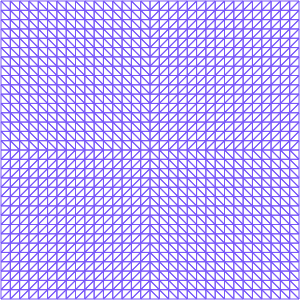

In [3]:
L = 5.0
mesh = MeshTri.init_sqsymmetric().refined(4)
mesh = mesh.scaled(2 * L).translated((-L, -L))
element = ElementTriP1()
basis = Basis(mesh,element)
source = np.array([1, 1])
mesh

## Simply analytics to compare to

In [4]:
def greens(a: float, s: np.ndarray, x: np.ndarray) -> np.ndarray:
    """Return the Green's function for a disk of radius `a`

    with source at point `s`, evaluated at points `x`.
    """

    snorm = np.linalg.norm(s)
    sfull = s[:, None, None]
    numerator = np.linalg.norm(snorm ** 2 * x - a ** 2 * sfull, axis=0)
    denominator = a * snorm * np.linalg.norm(x - sfull, axis=0)
    return np.log(numerator / denominator) / 2 / np.pi

Analytical Expression for Green's Func of $-\nabla^2$ is: $-\frac{1}{2\pi} ln(r)$

In [ ]:
# Bilinear form, as a matrix wrt basis elements. Namely a(e_i,e_j) = \int grad(e_i) grad(e_j), so specifically weak form for negative laplacian
A = asm(laplace, basis)



D = basis.get_dofs()
A_int, _, _ = condense(A, D=D, expand=True)

# Linear form, as a vector wrt to basis elements (point source)
# sources = basis.doflocs.T
# for source in sources:
#     b = basis.point_source(source)
#     num_zeros = np.count_nonzero(b == 0)
#     num_ones = np.count_nonzero(b == 1)

#     nonzero_indices = np.nonzero(b)

#     print(f"Len: {len(b)}, Zeroes: {num_zeros}, Ones: {num_ones} | First nonzero index: {nonzero_indices[0]}")


# condensed = condense(A, b, D=basis.get_dofs()) # a 4 tuple, containing A and b without the boundary dofs (applying bcs)
# x = solve(*condensed) # Destructure arguments

# print(b)

  (np.int32(0), np.int32(0))	1.0
  (np.int32(0), np.int32(289))	-0.5
  (np.int32(0), np.int32(290))	-0.5
  (np.int32(1), np.int32(1))	2.0
  (np.int32(1), np.int32(292))	-0.5
  (np.int32(1), np.int32(293))	-0.5
  (np.int32(1), np.int32(294))	-1.0
  (np.int32(2), np.int32(2))	1.0
  (np.int32(2), np.int32(295))	-0.5
  (np.int32(2), np.int32(297))	-0.5
  (np.int32(3), np.int32(3))	2.0
  (np.int32(3), np.int32(298))	-0.5
  (np.int32(3), np.int32(299))	-1.0
  (np.int32(3), np.int32(300))	-0.5
  (np.int32(4), np.int32(4))	4.0
  (np.int32(4), np.int32(302))	-1.0
  (np.int32(4), np.int32(304))	-1.0
  (np.int32(4), np.int32(305))	-1.0
  (np.int32(4), np.int32(307))	-1.0
  (np.int32(5), np.int32(5))	2.0
  (np.int32(5), np.int32(309))	-0.5
  (np.int32(5), np.int32(310))	-1.0
  (np.int32(5), np.int32(311))	-0.5
  (np.int32(6), np.int32(6))	1.0
  (np.int32(6), np.int32(312))	-0.5
  :	:
  (np.int32(1084), np.int32(283))	-1.0
  (np.int32(1084), np.int32(285))	-1.0
  (np.int32(1084), np.int32(673))	-1.

: 

L2 error: 0.41817032471114984


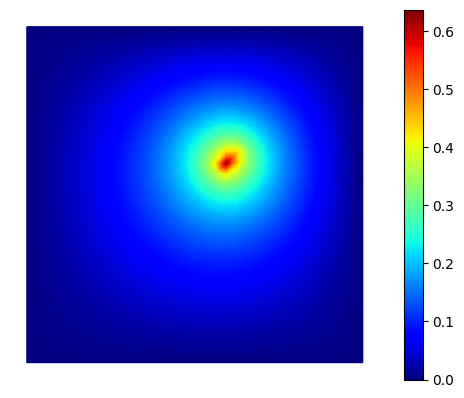

: 

In [ ]:
a = np.linalg.norm(basis.mesh.p, axis=0).max()
exact = basis.project(lambda x: greens(a, source, x))

error = x - exact
l2error = np.sqrt(error @ mass.assemble(basis) @ error)

def visualize():
    from skfem.visuals.matplotlib import plot
    return plot(basis,
                x,
                shading='gouraud',
                nrefs=2,
                colorbar=True)

if __name__ == "__main__":
    print("L2 error:", l2error)
    visualize().show()